# Import libraries

In [ ]:

import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

## Defining functions

In [3]:
# Because Pascal VOC (visual object class) Annotations have folder and path attributes those need to be updated 

def xml_update_path(xml_name: str, img_path: str, img_name: str, xml_path: str, new_xml_path: str):
    og_xml= str(xml_path+xml_name)
    try:
        tree = ET.parse(og_xml)
        update =tree.find('path')
        txt1=str(img_path+img_name)
        update.text=txt1
        update2 = tree.find('folder')
        update2.text='annotations'
        update3 = tree.find('filename')
        update3.text=img_name
        txt2=str(new_xml_path+xml_name)
        tree.write(txt2)
    except:
        pass

In [4]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [5]:
print(extract_info_from_xml('annotations/hd12.xml'))

{'bboxes': [{'class': 'person', 'xmin': 37, 'ymin': 679, 'xmax': 253, 'ymax': 1080}, {'class': 'person', 'xmin': 591, 'ymin': 662, 'xmax': 758, 'ymax': 1080}, {'class': 'person', 'xmin': 840, 'ymin': 663, 'xmax': 958, 'ymax': 1033}, {'class': 'helmet', 'xmin': 99, 'ymin': 682, 'xmax': 204, 'ymax': 759}, {'class': 'helmet', 'xmin': 630, 'ymin': 663, 'xmax': 700, 'ymax': 712}, {'class': 'helmet', 'xmin': 685, 'ymin': 678, 'xmax': 723, 'ymax': 716}, {'class': 'helmet', 'xmin': 869, 'ymin': 665, 'xmax': 922, 'ymax': 711}, {'class': 'brick', 'xmin': 266, 'ymin': 744, 'xmax': 622, 'ymax': 864}, {'class': 'vest', 'xmin': 56, 'ymin': 790, 'xmax': 247, 'ymax': 1052}, {'class': 'vest', 'xmin': 596, 'ymin': 735, 'xmax': 739, 'ymax': 927}, {'class': 'vest', 'xmin': 862, 'ymin': 703, 'xmax': 968, 'ymax': 861}, {'class': 'hopper', 'xmin': 1485, 'ymin': 875, 'xmax': 1915, 'ymax': 1080}, {'class': 'hook', 'xmin': 698, 'ymin': 11, 'xmax': 919, 'ymax': 134}], 'filename': 'hd12.jpg', 'image_size': (1920,

### Converting annotation files

In [6]:
# Dictionary that maps class names to IDs
classes=['person', 'helmet', 'vest',
'board', 'wood', 'rebar', 'brick', 'scaffold',
'handcart', 'cutter', 'ebox', 'hopper', 'hook',
'fence', 'slogan']

class_name_to_id_mapping = {j: i for i,j in enumerate(classes)}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [7]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]


# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    #print(info_dict)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 19846/19846 [01:49<00:00, 180.66it/s]


In [52]:
# # all in same folder 
# img_path=os.path.join('yolov5/images/') # path to images
# xml_path=os.path.join('yolov5/annotations/' # path original xml files
# new_xml_path=os.path.join('yolov5/new_annotations/' # path to updated xml files

# # name and count of each type
# voc_tkr_list=[('hd',2370), ('hook',3080), ('hpdji',1530), ('hpdr',4060), ('hptm',9360), ('sz',320), ('yf',1030), ('zl', 340)]

# #indexes in file names is inconsistent, thus two loops
# for name, count in voc_tkr_list:
#     for num in range(10):
#         filename=name+'0'+str(num)
#         xml_name=filename+'.xml'
#         img_name=filename+'.png'
#         xml_update_path(xml_name, img_path, img_name, xml_path, new_xml_path)

#     for num in range(count):
#         filename=name+str(num)
#         xml_name=filename+'.xml'
#         img_name=filename+'.png'
#         xml_update_path(xml_name, img_path, img_name, xml_path, new_xml_path)
# # check if there is a difference between two annotation folders
# %cd /Users/ramonmartin/Documents/pytorch_projects/voc/VOC2007/
# !diff <(ls -R1 Annotations) <(ls -R1 cor_annotations)

images/hook269.jpg


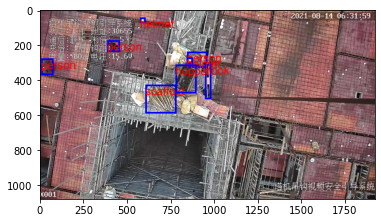

In [10]:
#random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline='blue', width=10)
        font_path= os.path.join('Arial.ttf')
        font1 = ImageFont.truetype(font_path, 65)
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], font=font1, fill='red')
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
assert os.path.exists(image_file)
print(image_file)
#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# Training

### Test Train Split

In [12]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images') if x [-3:] == 'jpg']
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


NameError: name 'os' is not defined

In [12]:
#create separate folders for test train val 
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test


In [13]:
#move files to respective folders
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

#Move the splits into their folders

move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [14]:
!mv annotations labels


### Parameter finetuning

In [16]:
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials


lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)

In [1]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data construction_data.yaml --weights yolov5s.pt --workers 24 --name yolo_rconst_det


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=construction_data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_rconst_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
Traceback (most recent call last):
  File "train.py", line 670, in <module>
    main(opt)
  File "train.py", line 540, in main
    check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.weights), str(opt.project)  # checks
  File "/home/jupyter/yv3/yolov5

### Running the model

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 100 --data construction_data.yaml --weights yolov5s.pt --workers 24 --name yolo_construction_det
#!python train.py --img 640 --batch 32 --epochs 30 --data construction_data.yaml --weights yolov5s.pt

# python train.py  # train a model
# python val.py --weights yolov5s.pt  # validate a model for Precision, Recall and mAP
# python detect.py --weights yolov5s.pt --source path/to/images  # run inference on images and videos
# python export.py --weights yolov5s.pt --include onnx coreml tflite 

In [ ]:
!python train.py --resume



wandb: Currently logged in as: jungzest. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
Resuming training from ./runs/train/yolo_construction_det7/weights/last.pt
YOLOv5 🚀 v6.1-256-gd605138 Python-3.7.12 torch-1.11.0+cu102 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

hyperparameters: lr0=0.01, 

In [1]:
!pwd

/home/jupyter/yv3/yolov5


In [ ]:
#interference over the dataset
!python detect.py --source ../Road_Sign_Dataset/images/test/ --weights runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name yolo_road_det


In [3]:
python detect.py --weights yolov5s.pt --source path/to/images